In [1]:
!nvidia-smi

Sat May  7 15:20:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Convolution Neural Networks


In [3]:
!gdown --id 1Bc0QfVLvfR-trwh8WMDemKPNxzg9D3OB
# https://drive.google.com/file/d/1Bc0QfVLvfR-trwh8WMDemKPNxzg9D3OB/view?usp=sharing

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Bc0QfVLvfR-trwh8WMDemKPNxzg9D3OB
To: /content/Assignment 3.zip
100% 47.3M/47.3M [00:00<00:00, 102MB/s]


In [4]:
import zipfile
import os 
zip_ref = zipfile.ZipFile('Assignment 3.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [5]:
os.chdir('/tmp')
os.getcwd()


'/tmp'

In [6]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
# for google collab, uncomment above and run

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


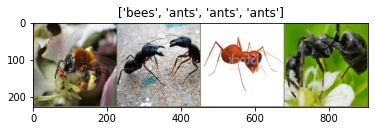

In [7]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


cudnn.benchmark = True
plt.ion()   # interactive mode

# Load Data

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
# data_dir = 'hmenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualizing a few Images 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs,lr,alpha,wd):
    train_losses=[]
    val_losses=[]
    train_accs=[]
    val_accs=[]
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            # epoch_loss = epoch_loss.cpu().detach().numpy
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu().detach().numpy()

            print(f'{phase} loss: {epoch_loss:.4f} \n{phase} accuracy: {epoch_acc:.4f}')

            if phase =='train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            # deep copy the model
            if phase == 'val' :
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    path1 = f'/content/drive/MyDrive/EE769_uploads/loss_{num_epochs}_{lr}_{alpha}_{wd}.png'
    path2 = f'/content/drive/MyDrive/EE769_uploads/accuracy_{num_epochs}_{lr}_{alpha}_{wd}.png'

    # Plotting
    plt.figure(figsize=(12,7))
    plt.plot(np.arange(1,num_epochs+1),train_losses,'r-', label='Training loss')
    plt.plot(np.arange(1,num_epochs+1),train_losses,'bo')
    plt.plot(np.arange(1,num_epochs+1),val_losses,'b-', label = "Validation loss")
    plt.plot(np.arange(1,num_epochs+1),val_losses,'ro')
    plt.title('Loss vs Epochs', fontsize=22)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.xticks(np.arange(1,num_epochs+1, 1),fontsize=14) 
    plt.yticks(fontsize=14) 
    plt.legend()
    plt.savefig(path1)
    plt.show()

    plt.figure(figsize=(12,7))
    plt.plot(np.arange(1,num_epochs+1),train_accs,'r-', label='Training accuracy')
    plt.plot(np.arange(1,num_epochs+1),train_accs,'bo')
    plt.plot(np.arange(1,num_epochs+1),val_accs,'b-', label = "Validation accuracy")
    plt.plot(np.arange(1,num_epochs+1),val_accs,'ro')
    plt.title('Accuracy vs Epochs', fontsize=22)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xticks(np.arange(1,num_epochs+1, 1),fontsize=14) 
    plt.yticks(fontsize=14) 
    plt.legend()
    plt.savefig(path2)
    plt.show()
    return model

Visualizing the model predictions

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

FineTuning the Covenet

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# for param in model_ft.parameters():
#     param.requires_grad = False

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
lr = 0.001 
momentum = 0.9
wd = 0.0
num_epochs = 75
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum,weight_decay=wd)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train and evaluate

Epoch 0/74
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train loss: 0.6073 
train accuracy: 0.6598
val loss: 0.2094 
val accuracy: 0.9281

Epoch 1/74
----------
train loss: 0.7306 
train accuracy: 0.7418
val loss: 0.3961 
val accuracy: 0.8627

Epoch 2/74
----------
train loss: 0.6019 
train accuracy: 0.8033
val loss: 0.2869 
val accuracy: 0.8954

Epoch 3/74
----------
train loss: 0.4739 
train accuracy: 0.8197
val loss: 0.2438 
val accuracy: 0.9216

Epoch 4/74
----------
train loss: 0.4971 
train accuracy: 0.8197
val loss: 0.2940 
val accuracy: 0.9085

Epoch 5/74
----------
train loss: 0.5830 
train accuracy: 0.7623
val loss: 0.4542 
val accuracy: 0.8366

Epoch 6/74
----------
train loss: 0.5230 
train accuracy: 0.8115
val loss: 0.3611 
val accuracy: 0.8889

Epoch 7/74
----------
train loss: 0.5368 
train accuracy: 0.7828
val loss: 0.3290 
val accuracy: 0.8954

Epoch 8/74
----------
train loss: 0.3869 
train accuracy: 0.8279
val loss: 0.2589 
val accuracy: 0.9150

Epoch 9/74
----------
train loss: 0.3688 
train accuracy: 0.8566
val loss: 0.

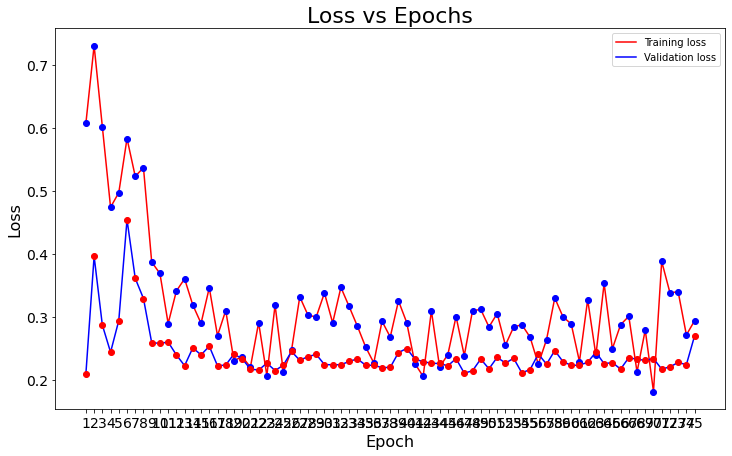

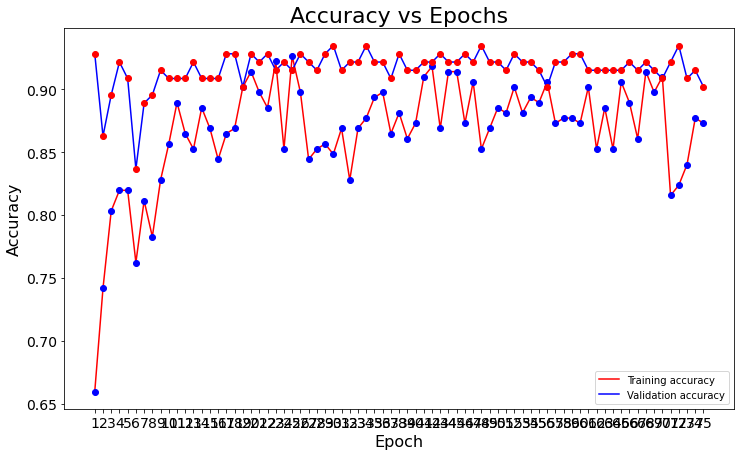

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


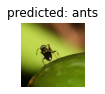

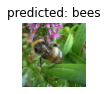

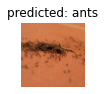

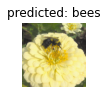

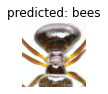

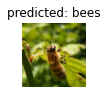

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=num_epochs,lr=lr,alpha=momentum, wd =wd)

visualize_model(model_ft)


Epoch 0/99
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train loss: 0.2234 
train accuracy: 0.9139
val loss: 0.2301 
val accuracy: 0.9281

Epoch 1/99
----------
train loss: 0.2811 
train accuracy: 0.8893
val loss: 0.2393 
val accuracy: 0.9216

Epoch 2/99
----------
train loss: 0.2474 
train accuracy: 0.9098
val loss: 0.2141 
val accuracy: 0.9216

Epoch 3/99
----------
train loss: 0.2072 
train accuracy: 0.9057
val loss: 0.2253 
val accuracy: 0.9281

Epoch 4/99
----------
train loss: 0.2522 
train accuracy: 0.8975
val loss: 0.2472 
val accuracy: 0.9150

Epoch 5/99
----------
train loss: 0.3470 
train accuracy: 0.8443
val loss: 0.2212 
val accuracy: 0.9281

Epoch 6/99
----------
train loss: 0.2855 
train accuracy: 0.8730
val loss: 0.2250 
val accuracy: 0.9281

Epoch 7/99
----------
train loss: 0.3154 
train accuracy: 0.8525
val loss: 0.2225 
val accuracy: 0.9216

Epoch 8/99
----------
train loss: 0.3708 
train accuracy: 0.8484
val loss: 0.2165 
val accuracy: 0.9281

Epoch 9/99
----------
train loss: 0.2778 
train accuracy: 0.8852
val loss: 0.

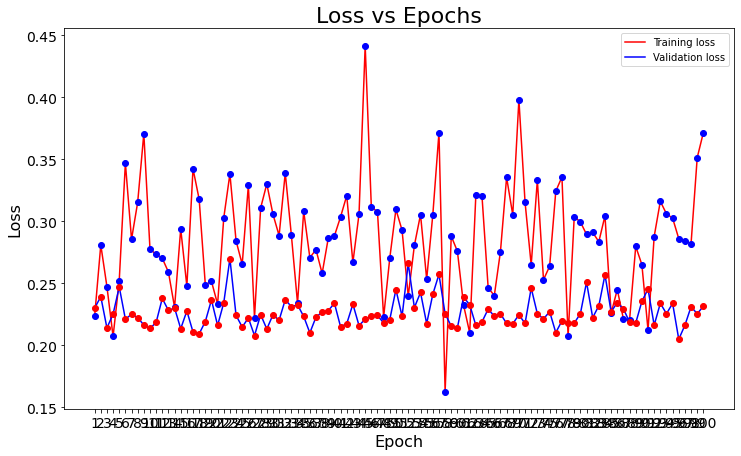

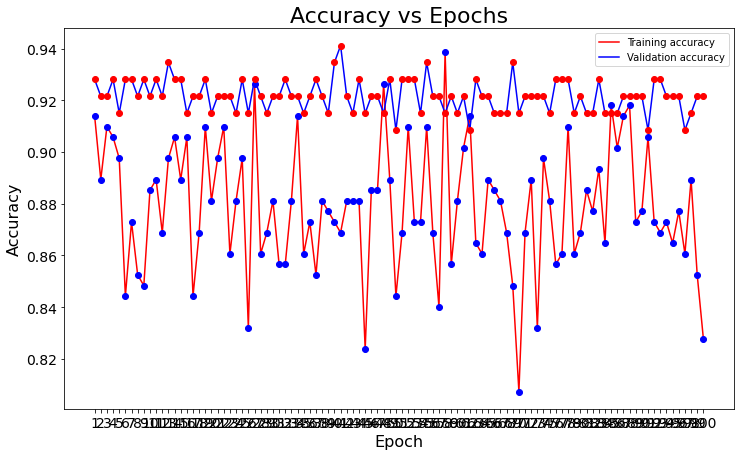

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


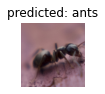

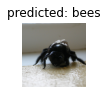

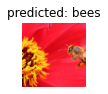

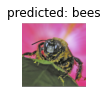

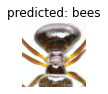

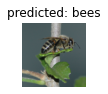

In [12]:
model_ft2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=100,lr=0.0001,alpha=0.98, wd =wd)

visualize_model(model_ft2)

Epoch 0/59
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train loss: 0.2771 
train accuracy: 0.9016
val loss: 0.2186 
val accuracy: 0.9346

Epoch 1/59
----------
train loss: 0.2943 
train accuracy: 0.8770
val loss: 0.2253 
val accuracy: 0.9346

Epoch 2/59
----------
train loss: 0.2391 
train accuracy: 0.8852
val loss: 0.2315 
val accuracy: 0.9150

Epoch 3/59
----------
train loss: 0.2684 
train accuracy: 0.8730
val loss: 0.2166 
val accuracy: 0.9216

Epoch 4/59
----------
train loss: 0.3050 
train accuracy: 0.8648
val loss: 0.2442 
val accuracy: 0.9346

Epoch 5/59
----------
train loss: 0.2320 
train accuracy: 0.8975
val loss: 0.2211 
val accuracy: 0.9150

Epoch 6/59
----------
train loss: 0.2069 
train accuracy: 0.9098
val loss: 0.2227 
val accuracy: 0.9020

Epoch 7/59
----------
train loss: 0.2481 
train accuracy: 0.9057
val loss: 0.2137 
val accuracy: 0.9346

Epoch 8/59
----------
train loss: 0.3089 
train accuracy: 0.8607
val loss: 0.2290 
val accuracy: 0.9281

Epoch 9/59
----------
train loss: 0.3496 
train accuracy: 0.8525
val loss: 0.

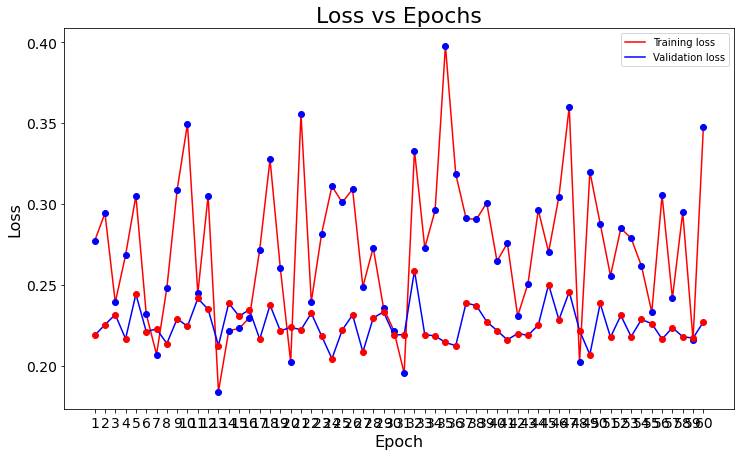

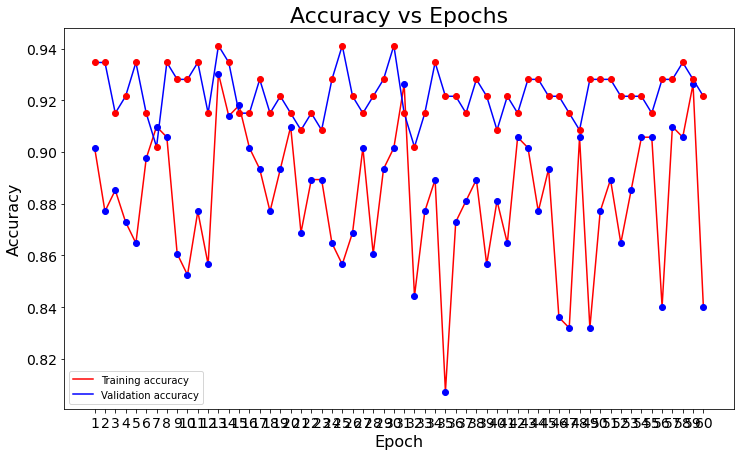

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


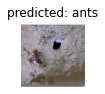

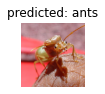

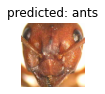

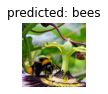

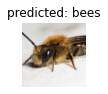

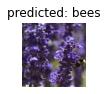

In [13]:
model_ft3 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=60,lr=0.0025,alpha=0.95, wd =wd)

visualize_model(model_ft3)